In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from multiprocessing.pool import ThreadPool
from multiprocessing import cpu_count
max_cpu = cpu_count()

# Homework (Lecture 9)
## Problem 1

### Part (a)

$X_i \sim Exp(\lambda), \lambda >0 $

$\displaystyle \sum_{i=1}^{100} \log(\lambda e^{-\lambda X_i}) \cdot 1(X_i > 0) = \sum_{i=1}^{100} \log(\lambda e^{-\lambda X_i}) = 100 log(\lambda) - \lambda \sum_{i=1}^{100} X_i$

$\frac{\partial}{\partial \lambda} ( 100 log(\lambda) - \lambda \sum_{i=1}^{100} X_i) = \frac{100}{\lambda} - \sum_i X_i \Rightarrow \hat{\lambda} = \displaystyle \frac{1}{\bar{X}}$

To find the asymptotic variance of $\hat{\lambda}$, we can apply the Delta Method. In particular, since $\sqrt{n} (\bar{X} - \mu) \overset{d}{\to} N(0, \sigma^2)$, where $\mu = \displaystyle \frac{1}{\lambda}, \sigma^2 = \frac{1}{\lambda^2}$, we can say that $\sqrt{n} (\hat{\lambda} - \lambda) \overset{d}{\to} N(0, \sigma^2 \cdot  (\frac{1}{-\frac{1}{\lambda^2}})^2) = N(0, \lambda^2)$. The asymptotic variance of the MLE estimator is $\lambda^2$.

**Look at lecture 7 for asymptotic variance**

### Part (b)

Given $\hat{\lambda}^{MLE}$, we can use the estimated CDF of X to find $\displaystyle P(X \le 1) = 1- e^{-\lambda \cdot 1} = 1- e^{-\hat{\lambda}^{MLE}} = 1- e^{-\frac{1}{\bar{X}}}$ = 0.918.

### Part (c)

Similarly to Part (a), since we have $\displaystyle \sqrt{n} (\bar{X} - \frac{1}{\lambda}) \overset{d}{\to} N(0, \frac{1}{\lambda^2})$, to construct a 95% CI for $P(X \le 1)$, we can show that $\displaystyle \sqrt{n} (\hat{P} - P) \overset{d}{\to} N(0, \frac{1}{\lambda^2} \cdot (1+e^{-\lambda})^2) = N(0, (\frac{1+e^{-\lambda}}{\lambda})^2 )$

Now that we have the asymptotic variance of this estimator, we can construct a 95% CI: $\hat{p} \pm 1.96 \times se(\hat{p}) = 1- e^{-\frac{1}{\bar{X}}} \pm 1.96 \times \frac{\sigma}{\sqrt{n}} = 0.9179 \pm 0.08484$

derivative should be $e^{-\lambda}$ and use the corrected variance from (a)

### Part (d)

$\hat{P}(X \le 1) = 0.8 \Rightarrow \frac{1}{n} \sum_{i=1}^{100} 1(X \le 1) = 0.8$. Since the sum of Bernoulli random variables follows a binomial distribution, we know the variance is $npq = (100)(0.8)(0.2) = 16$. By the CLT, we see that $\hat{p}_n \sim N(\mu, \frac{\sigma^2}{n}) = N(0.8,0.16)$. As such, a 95% CI for $\hat{p}_n$ is: $\hat{p}_n \pm 1.96 \times se(\hat{p}_n) = 0.8 \pm 0.0784$

### Part (e)

I would trust the one from Part (d) more since it makes fewer assumptions about the true distribution of the data.

## Problem 2

### Part (a)

In [153]:
from scipy.interpolate import splrep
from scipy.interpolate import BSpline

def DGP():
    V = np.random.exponential(scale=2,size = 200)
    X = 1 + V
    epsilon = np.random.normal(0,np.sqrt(0.5),size=200)
    Y = 2 + 2 * np.log(X) + epsilon
    temp = np.sort(np.column_stack((X,Y)),axis=0)
    X, Y = temp[:,0], temp[:,1]
    
    return X, Y

def gauss_kernel(u):
    return (1/np.sqrt(2*np.pi)) * np.exp(-(u ** 2)/2)

def LL(X,Y,x,h):
    Z = np.column_stack((np.ones(X.shape[0]),X-x))
    K = np.diag(gauss_kernel((X-x)/h))
    m_vec = np.linalg.inv(Z.T @ K @ Z) @ Z.T @ K @ Y
    return m_vec[0], m_vec[1]

def NN(X,Y,x,k):
    x_norm = np.abs(X-x)
    m = (1/k) * np.sum(np.sort(np.column_stack((x_norm,Y)),axis=0)[-k:,1])
    return m

def series(X,Y,num_knots):
    t, c, k = splrep(X,Y, s=0, k=3)
    knots = np.linspace(t.min(), t.max(), num_knots)
    spline = BSpline(t, c, k, extrapolate=False)
    return spline

def loo_ll_cv(param):
    X,Y = DGP()
    total = 0
    for i in range(X.shape[0]):
        m, delt_m = LL(np.delete(X,i),np.delete(Y,i),X[i],param)
        y_hat = m + delt_m * X[i]
        total += y_hat - Y[i]
    return param, total

def loo_nn_cv(param):
    X,Y = DGP()
    total = 0
    for i in range(X.shape[0]):
        m, delt_m = NN(np.delete(X,i),np.delete(Y,i),X[i],param)
        y_hat = m + delt_m * X[i]
        total += y_hat - Y[i]
    return param, total

def cv_viz(fn,params):
    with ThreadPool(max_cpu - 1) as pool:
        output = pool.map(fn,params)
    df = pd.DataFrame(output,columns=['Parameter','Total Error'])
    plt.figure(figsize=[8,5])
    plt.scatter(x = df['Parameter'], y = df['Total Error'])
    plt.xlabel('Parameter Value')
    plt.ylabel('Total Error')

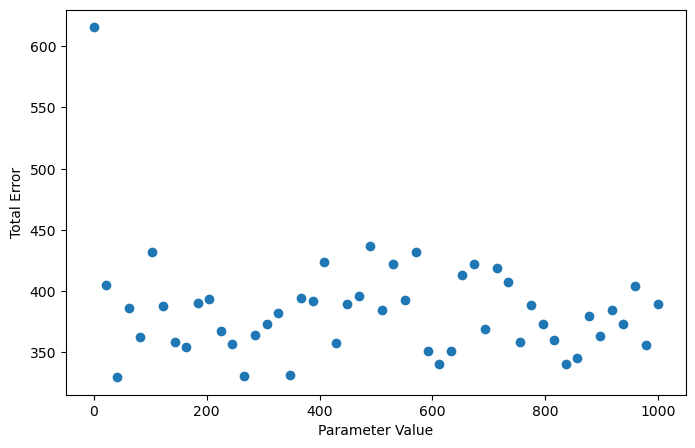

In [167]:
params = np.linspace(0.1,1000,50)
cv_viz(loo_ll_cv,params)

In [126]:
X,Y = DGP() 
t, c, k = splrep(X,Y, s=0, k=3)

# Homework (Lecture 11)

## Problem 1

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

In [5]:
def DGP():
    X = np.concatenate((np.random.normal(2,1,size=(300,1)),
                        np.random.normal(4,1,size=(300,1))),axis=1)
    y = (X.sum(axis=1) + np.random.normal(300)).reshape(300,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, random_state=31)
    return X_train, X_test, y_train, y_test

def tree_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = DecisionTreeRegressor(ccp_alpha = param, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def rf_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = RandomForestRegressor(max_features = param, n_jobs = -1, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def boost_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = GradientBoostingRegressor(max_leaf_nodes = param, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def cv_viz(fn,params):
    with ThreadPool(max_cpu - 1) as pool:
        output = pool.map(fn,params)
    df = pd.DataFrame(output,columns=['Parameter','MSE'])
    plt.figure(figsize=[8,5])
    plt.scatter(x = df['Parameter'], y = df['MSE'])
    plt.xlabel('Parameter Value')
    plt.ylabel('MSE')

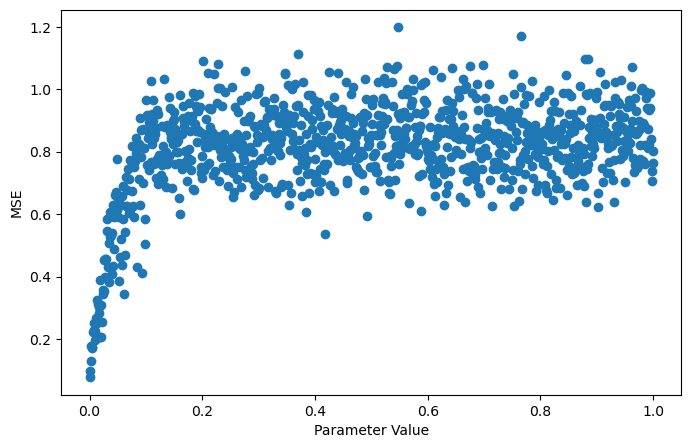

In [6]:
params = np.linspace(0,1,1000)
cv_viz(tree_cv,params)

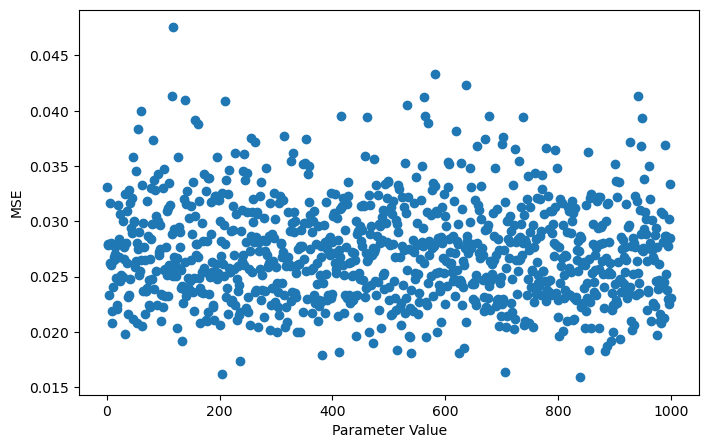

In [12]:
params = np.linspace(1,1000,1000,dtype=int)
cv_viz(rf_cv,params)

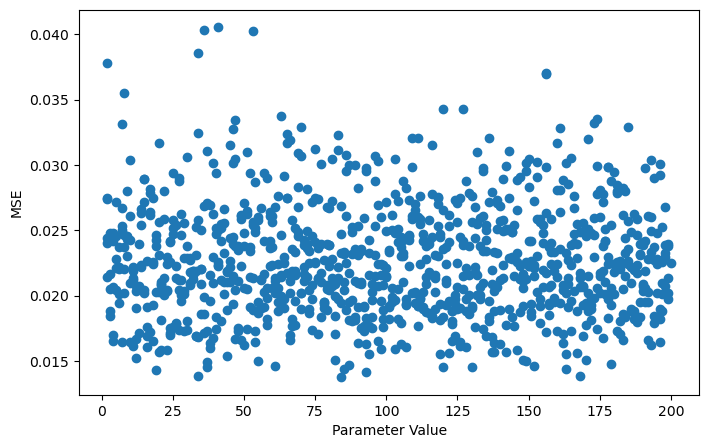

In [13]:
params = np.linspace(2,200,1000,dtype=int)
cv_viz(boost_cv,params)

Note:

**DON'T FORGET TO SET RANDOM STATE FOR EACH MODEL**

- for tree, use ccp_alpha parameter for tuning - Minimal cost-complexity pruning based on Chapter 3 of Breiman et al (1984)
- for rf, select num regressors for each split p using max_features: The number of features to consider when looking for the best split
- for boosted tree, choose number of leaves using max_leaf_nodes parameter

In [ ]:
# training optimal models
X_train, X_test, y_train, y_test = DGP()

tree = DecisionTreeRegressor(ccp_alpha = 0, random_state=31).fit(X_train,y_train)
rf = RandomForestRegressor(max_features = param, n_jobs = -1, random_state=31).fit(X_train,y_train)
bost = GradientBoostingRegressor(max_leaf_nodes = param, random_state=31).fit(X_train,y_train)

In [ ]:
print('Tree:')
mean_squared_error(y_test, tree.predict(X_test))

print('RF:')
mean_squared_error(y_test, rf.predict(X_test))

print('Boost:')
mean_squared_error(y_test, boost.predict(X_test))

## Problem 2

### Part (1)

In [2]:
df = pd.read_csv('penn.csv')

In [4]:
sub_df = df.loc[(df['tg'] == 0) | (df['tg'] == 4)].iloc[:,1:]

### Part (2)

In [5]:
Y = np.log(sub_df['inuidur1']).to_numpy()
D = np.where(sub_df['tg']==4,1,0).reshape(sub_df.shape[0],1)
W = sub_df[['female', 'black', 'hispanic', 'othrace','agelt35', 'agegt54']].to_numpy()

### Part (3)

### Part (4)

Estimating $E[Y|D,W] = \beta_0 (W) + D \beta_1(W) = \beta_1 + \beta_3 W + \beta_2 D + \beta_4 D \cdot W$

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
X = np.concatenate((W,D,D * W),axis=1)

In [12]:
len(reg.coef_)

13

In [9]:
reg = LinearRegression()
reg.fit(X,Y)
print(reg.intercept_)
print(reg.coef_)

2.1666156650050383
[ 0.05991235 -0.30535729 -0.36817296 -0.44858    -0.17948479  0.13428484
 -0.16281088  0.09674223  0.07426992  0.28011734 -0.04566471  0.01753088
  0.15569122]


$\beta_1 = 2.1666156650050383$ 

$\beta_3 = \begin{bmatrix}
                0.05991235 \\
                -0.30535729 \\
                -0.36817296 \\
                -0.44858 \\
                -0.17948479 \\
                0.13428484
            \end{bmatrix}$
            
$\beta_2 = -0.16281088$

$\beta_4 = \begin{bmatrix}
                0.09674223 \\
                0.07426992 \\
                0.28011734 \\
                -0.04566471 \\
                0.01753088 \\
                0.15569122
            \end{bmatrix}$

### Part (5)


b0(w) uses subsample where everyone is control and b1(w) is where everyone is treated on Y minus the fitted values of b0(w)